In [1]:
import csv
from edgeDetection import *
import os
import matplotlib
# matplotlib.use('PS')
import matplotlib.pyplot as plt
import numpy as np
from readTabTxtFile import *
from calTempResolution import *
from trimmedTriggerTime import *
import scipy

import pickle
from sklearn.model_selection import train_test_split
import torch
import random
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
directory = "/media/watson/UbuntuHDD/feng_Xin/Xin/Miniscope/5133307132023/reward_seeking/days_with_miniscope_recording/day25/11_53_12"

# for 49140 and 49142
# frameInput = 0
# lickTrigNum = 1
# pokeTrigNum = 2
# caTimeNum = 0
# pumpTrigNum = 4

# for 51331, 51332 and 51333
frameInput = 3
lickTrigNum = 2
pokeTrigNum = 0
caTimeNum = 3
pumpTrigNum = 1

validIdFile = "validIdx.txt"
cellTracesFile = "cellTraces_norm.txt"
pokeTriggerFile = "stim"+str(pokeTrigNum)+".txt"
lickTriggerFile = "stim"+str(lickTrigNum)+".txt"
pumpTriggerFile = "stim"+str(pumpTrigNum)+".txt"

caTimeFile = "stim"+str(caTimeNum)+".txt"
plotSavingFolder = 'Plots'
videoFrameNum = 1000

plotSavingFolder = 'Plots'
with open(directory + os.sep + 'frame_correction_pos.pickle','rb') as f:
    frame_correction = pickle.load(f)

def findClosestTimeIndex(t,tSeries):
    tDiff = [abs(t-i) for i in tSeries]
    nd_tDiff = np.array(tDiff)
    pos = np.argmin(nd_tDiff)
    return pos
def findClosestLickIndex(t1Series,refT,tSeries):
    tDiff = [[i-refT,i] for i in t1Series if i-refT>=0]
    nd_tDiff = np.array(tDiff)
    lick_pos = np.argmin(nd_tDiff[:,0])
    pos = findClosestTimeIndex(nd_tDiff[lick_pos,1],tSeries)
    return pos

def findAfterClosestIndex(t1Series,refT,tSeries):
    tDiff = [[i-refT,i] for i in t1Series if i-refT>=0]
    nd_tDiff = np.array(tDiff)
    lick_pos = np.argmin(nd_tDiff[:,0])
    pos = findClosestTimeIndex(nd_tDiff[lick_pos,1],tSeries)
    return pos

def findBeforeClosestIndex(t1Series,refT,tSeries):
    tDiff = [[i-refT,i] for i in t1Series if i-refT<=0]
    nd_tDiff = np.array(tDiff)
    lick_pos = np.argmax(nd_tDiff[:,0])
    pos = findClosestTimeIndex(nd_tDiff[lick_pos,1],tSeries)
    return pos

def findAllLickIndices(t1Series,refT,tSeries,window):
    pos=[]
    tDiff = [[i - tSeries[refT], i] for i in t1Series if i-tSeries[refT]>0 and i-tSeries[refT]-window*caFrameDur<0]
    nd_tDiff = np.array(tDiff)
    for i in nd_tDiff:
        pos_temp = findClosestTimeIndex(i[1],tSeries)
        pos.append(pos_temp)
    return pos

def interpolateNaN(x):
    loc = np.argwhere(np.isnan(x))
    for i in loc:
        x[i[0]] = (x[i[0]-1] + x[i[0]+1])/2
    return x
with open(directory+os.sep+cellTracesFile, "r", newline="\n") as readFile:
    data_reader = readFile.readlines()
# with open(directory+os.sep+validIdFile, "r", newline="") as readFile:
#     id_reader = readFile.readlines()
# with open(directory+os.sep+triggerFile, "r", newline="") as readFile:
#     trig_reader = readFile.readlines()
# with open(directory+os.sep+caTimeFile, "r", newline="") as readFile:
#     caTime_reader = readFile.readlines()

caData = readTabTxtFile(directory+os.sep+cellTracesFile, 'float')
valid_idx = readTabTxtFile(directory+os.sep+validIdFile, 'int')
pokeTrigTime = readTabTxtFile(directory+os.sep+pokeTriggerFile, 'float')
lickTrigTime = readTabTxtFile(directory+os.sep+lickTriggerFile, 'float')
caTime = readTabTxtFile(directory+os.sep+caTimeFile, 'float')
caFrameDur = calTempResolution(caTime)
pumpTrigTime = readTabTxtFile(directory+os.sep+pumpTriggerFile, 'float')

# valid_idx = [int(i) for i in id_reader[0].strip().split("\t")]
# caTime = [float(i) for i in caTime_reader[0].strip().split("\t")]
# trigTime = [float(i) for i in trig_reader[0].strip().split("\t")]
numVideoShift = 0
preTrigWindow_poke = -100
postTrigWindow_poke = 100
preTrigWindow_lick = -100
postTrigWindow_lick = 100
len_window = postTrigWindow_poke-preTrigWindow_poke
trimmed_pokeTrigTime = trimmedTriggerTime(pokeTrigTime,caTime,videoFrameNum*numVideoShift,-1)
trimmed_lickTrigTime = trimmedTriggerTime(lickTrigTime,caTime,videoFrameNum*numVideoShift,-1)
trimmed_pumpTrigTime = trimmedTriggerTime(pumpTrigTime,caTime,videoFrameNum*numVideoShift,-1)

# numTrig = len(trimmed_pokeTrigTime)
numTrig_pump = len(trimmed_pumpTrigTime)
numTrig_poke = len(trimmed_pokeTrigTime)
numTrig_lick = len(trimmed_lickTrigTime)

numData = len(caData)
numAnalysisWindow = -1*preTrigWindow_poke+postTrigWindow_poke
pokeTimeAdj = 0.03

# zscore_ca_good = np.zeros((len(valid_idx),numTrig_pump,len_window))
# zscore_ca_poke = np.zeros((len(valid_idx),1,len_window))
# zscore_ca_lick = np.zeros((len(valid_idx),1,len_window))

zscore_ca_good = np.array([])
zscore_ca_poke = np.array([])
zscore_ca_lick = np.array([])
zscore_ca_noTrig = np.array([])

In [3]:
ca_trace_isTrig = np.zeros(len(caTime))

for trig_id in range(numTrig_poke):
    try:

        ca_pos_temp_poke = findClosestTimeIndex(trimmed_pokeTrigTime[trig_id], caTime)
        ca_pos_poke = ca_pos_temp_poke - videoFrameNum * numVideoShift
        ca_trace_isTrig[ca_pos_poke + preTrigWindow_poke: ca_pos_poke + postTrigWindow_poke] = 1
        
    except:
        print("Analysis window is outside ca2+ data size")
for trig_id in range(numTrig_lick):
    try:

        ca_pos_temp_lick = findClosestTimeIndex(trimmed_pokeLickTime[trig_id], caTime)
        ca_pos_lick = ca_pos_temp_lick - videoFrameNum * numVideoShift
        ca_trace_isTrig[ca_pos_lick + preTrigWindow_lick: ca_pos_lick + postTrigWindow_lick] = 1
        
    except:
        print("Analysis window is outside ca2+ data size")

Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ da

In [4]:
for i in range(len(valid_idx)):
    ca_trace = scipy.stats.zscore([float(k) for k in data_reader[valid_idx[i]].strip().split("\t")])
    if frame_correction:
        ca_trace_corrected = interpolateNaN(np.concatenate((ca_trace[0:frame_correction[0]+1],[float('NaN')]*frame_correction[1],ca_trace[frame_correction[0]+1:])))
    else:
        ca_trace_corrected = ca_trace

    ca_raw_traces_poke = []
    ca_raw_traces_lick = []
    ca_raw_traces_noTrig = []

    for trig_id in range(numTrig_pump): 

        try:
            ca_pos_temp_pump = findClosestTimeIndex(trimmed_pumpTrigTime[trig_id], caTime)
            ca_pos_temp_poke = findBeforeClosestIndex(trimmed_pokeTrigTime, trimmed_pumpTrigTime[trig_id], caTime)
            ca_pos_temp_lick = findAfterClosestIndex(trimmed_lickTrigTime, caTime[ca_pos_temp_poke], caTime)

            ca_pos_poke = ca_pos_temp_poke - videoFrameNum * numVideoShift
            ca_pos_lick = ca_pos_temp_lick - videoFrameNum * numVideoShift
            ca_pos_pump = ca_pos_temp_pump - videoFrameNum * numVideoShift
            

            plot_ca_poke = ca_trace_corrected[ca_pos_poke + preTrigWindow_poke: ca_pos_poke + postTrigWindow_poke]
            plot_ca_lick = ca_trace_corrected[ca_pos_lick + preTrigWindow_lick: ca_pos_lick + postTrigWindow_lick]

            if np.any(np.isnan(plot_ca_poke)) or np.any(np.isnan(plot_ca_lick)):
                print('there is an NaN','current i is:',i,'current trig id is:',trig_id,sep='')

                continue
            else:
                if len(plot_ca_poke)==numAnalysisWindow:
                    ca_raw_traces_poke.append(plot_ca_poke)
    
                if len(plot_ca_lick)==numAnalysisWindow:
                    ca_raw_traces_lick.append(plot_ca_lick)
        except:
            print("Analysis window is outside ca2+ data size")
    if i == 0:
        zscore_ca_poke = ca_raw_traces_poke
        zscore_ca_poke = np.expand_dims(zscore_ca_poke,axis=0)
        zscore_ca_lick = ca_raw_traces_lick
        zscore_ca_lick = np.expand_dims(zscore_ca_lick,axis=0)
    
    else:
        zscore_ca_poke = np.append(zscore_ca_poke,np.expand_dims(ca_raw_traces_poke,axis=0),axis=0)
        zscore_ca_lick = np.append(zscore_ca_lick,np.expand_dims(ca_raw_traces_lick,axis=0),axis=0)


    i_noTrig = 0
    bool_isTrig = np.array(ca_trace_isTrig,dtype='bool')
    while i_noTrig<len(bool_isTrig)-len_window:
        
        if np.any(bool_isTrig[i_noTrig:i_noTrig+len_window]):
            i_noTrig = i_noTrig+1
        else:
            plot_ca = ca_trace_corrected[i_noTrig: i_noTrig + len_window]
            
            if np.any(np.isnan(plot_ca)):
                # print(i_noTrig)
                ca_trace_isTrig[i_noTrig: i_noTrig + len_window] = 1
                i_noTrig = i_noTrig + len_window
            else:
                
                # ca_raw_traces_noTrig.append(plot_ca)
                i_noTrig = i_noTrig + len_window
    # if np.any(np.isnan(scipy.stats.zscore(ca_raw_traces_noTrig,axis=1,nan_policy='omit'))):
    #     continue
    # else:
    #     if i==0:
            
    #         zscore_ca_noTrig = scipy.stats.zscore(ca_raw_traces_noTrig,axis=1,nan_policy='omit')
    #         zscore_ca_noTrig = np.expand_dims(zscore_ca_noTrig,axis=0)
    #     else:
    #         zscore_ca_noTrig = np.append(zscore_ca_noTrig,np.expand_dims(scipy.stats.zscore(ca_raw_traces_noTrig,axis=1,nan_policy='omit'),axis=0),axis=0)


Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ da

In [5]:
for i in range(len(valid_idx)):
    ca_trace = scipy.stats.zscore([float(k) for k in data_reader[valid_idx[i]].strip().split("\t")])
    if frame_correction:
        ca_trace_corrected = interpolateNaN(np.concatenate((ca_trace[0:frame_correction[0]+1],[float('NaN')]*frame_correction[1],ca_trace[frame_correction[0]+1:])))
    else:
        ca_trace_corrected = ca_trace

    ca_raw_traces_noTrig = []
    
    i_noTrig = 0
    bool_isTrig = np.array(ca_trace_isTrig,dtype='bool')
    while i_noTrig<len(bool_isTrig)-len_window:
        if np.any(bool_isTrig[i_noTrig:i_noTrig+len_window]):
            i_noTrig = i_noTrig+1
        else:
            plot_ca = ca_trace_corrected[i_noTrig: i_noTrig + len_window]

            ca_raw_traces_noTrig.append(plot_ca)
            i_noTrig = i_noTrig + len_window
    # if np.any(np.isnan(scipy.stats.zscore(ca_raw_traces_noTrig,axis=1,nan_policy='omit'))):
    #     print(i)
    #     continue
    # else:
    if i==0:
        
        zscore_ca_noTrig = ca_raw_traces_noTrig
        zscore_ca_noTrig = np.expand_dims(zscore_ca_noTrig,axis=0)
    else:
        zscore_ca_noTrig = np.append(zscore_ca_noTrig,np.expand_dims(ca_raw_traces_noTrig,axis=0),axis=0)

In [6]:
use_prebuilt = 1
if use_prebuilt:
    zscore_poke = np.transpose(zscore_ca_poke,(1,0,2))
    zscore_lick = np.transpose(zscore_ca_lick,(1,0,2))
    zscore_noTrig_origin = np.transpose(zscore_ca_noTrig,(1,0,2))
else:
    zscore_poke = np.transpose(zscore_ca_poke,(1,2,0))
    zscore_lick = np.transpose(zscore_ca_lick,(1,2,0))
    zscore_noTrig_origin = np.transpose(zscore_ca_noTrig,(1,2,0))

In [7]:
# dummy,zscore_noTrig_test_ind = train_test_split(np.arange(0,zscore_noTrig_origin.shape[0]),test_size=zscore_poke.shape[0]/zscore_noTrig_origin.shape[0])
# zscore_noTrig = zscore_noTrig_origin[zscore_noTrig_test_ind,:]


In [8]:
zscore_poke.shape

(53, 29, 200)

In [9]:
X = np.concatenate((zscore_noTrig_origin, zscore_poke,zscore_lick),axis=0)
Y = np.concatenate((np.zeros(zscore_noTrig_origin.shape[0]),np.ones(zscore_poke.shape[0])*1,np.ones(zscore_lick.shape[0])*2),axis=0)
x_train, x_test, y_train, y_test=train_test_split(X,Y,test_size=0.3,stratify = Y)


In [10]:
def randomChoice(l):
    return random.randint(0, l.size - 1)

def randomTrainingExample():
    category_ind = randomChoice(y_train)
    features_vector = x_train[category_ind,:,:]
    category_tensor = torch.tensor([y_train[category_ind]], dtype=torch.long).to(device)
    features_tensor = lineToTensor(features_vector)
    return y_train[category_ind], features_vector, category_tensor, features_tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(vector):
    shape = vector.shape

    tensor = torch.zeros(shape[0], 1, shape[1]).to(device)
    for li in range(shape[0]):
        tensor[li][0][:] = torch.tensor(vector[li,:])
    return tensor

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    print(hidden.shape,line_tensor.shape)

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


def randomTestingExample():
    category_ind = randomChoice(y_test)
    features_vector = x_test[category_ind,:,:]
    category_tensor = torch.tensor([y_test[category_ind]], dtype=torch.long).to(device)
    features_tensor = lineToTensor(features_vector)
    return y_test[category_ind], features_vector, category_tensor, features_tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return category_i


In [11]:
# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(RNN, self).__init__()

#         self.hidden_size = hidden_size

#         self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
#         self.h2o = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, input, hidden):
#         combined = torch.cat((input, hidden), 1).to(device)
#         hidden = self.i2h(combined)
#         output = self.h2o(hidden)
#         output = self.softmax(output)
#         return output, hidden

#     def initHidden(self):
#         return torch.zeros(1, self.hidden_size).to(device)

# n_hidden = 64
# n_categories = 3
# n_features = len(valid_idx)
# rnn = RNN(n_features, n_hidden, n_categories)
# rnn.to(device)


In [12]:
n_hidden = 128
n_categories = 3
n_features = len_window
input_size=n_features
hidden_size=n_hidden
num_classes=n_categories
num_layers = 3
sequence_length=len(valid_idx)
bidirectional = False
class RNN(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,sequence_length=sequence_length,birectional=bidirectional):
        super(RNN, self).__init__()
        if bidirectional:
            d = 2
        else:
            d = 1
        self.num_layers = num_layers
        self.bidirectional = d
        self.hidden_size= hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,bidirectional=bidirectional)

        self.fc1 = nn.Linear(hidden_size * sequence_length * d, num_classes)

    def forward(self, x):
        
        h0 = torch.zeros(self.bidirectional*self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        output = self.fc1(out)
        return output
        

rnn = RNN()
rnn.to(device)


In [13]:
# n_hidden = 128
# n_categories = 3
# n_features = len_window
# input_size=n_features
# hidden_size=n_hidden
# num_classes=n_categories
# num_layers = 1
# sequence_length=len(valid_idx)
# class LSTM(nn.Module):
#     def __init__(self, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, sequence_length=sequence_length, num_classes=num_classes):
#         super(LSTM, self).__init__()
        
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
        
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc1 = nn.Linear(hidden_size * sequence_length, num_classes)
        
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=device)
        
#         out, _ = self.lstm(x,(h0, c0))
#         out = out.reshape(out.size(0), -1)
#         out = self.fc1(out)
#         return out
    
# lstm = LSTM()
# lstm.to(device)

LSTM(
  (lstm): LSTM(200, 128, batch_first=True)
  (fc1): Linear(in_features=3712, out_features=3, bias=True)
)

In [14]:
# n_hidden = 64
# n_categories = 3
# n_features = len_window
# input_size=n_features
# hidden_size=n_hidden
# num_classes=n_categories
# num_layers=1
# sequence_length=len(valid_idx)

# class GRU(nn.Module):
#     def __init__(self, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,sequence_length=sequence_length):
#         super(GRU, self).__init__()
#         self.hidden_size  = hidden_size
#         self.num_layers = num_layers
        
#         self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc1 = nn.Linear(hidden_size * sequence_length, num_classes)
    
#     def forward(self, input):
#         h0 = torch.zeros(self.num_layers, input.size(0), self.hidden_size).to(device)
        
#         out,_ = self.gru(input, h0)
#         out = out.reshape(out.shape[0], -1)
        
#         output = self.fc1(out)
#         return output


# gru = GRU()
# gru.to(device)

In [15]:
learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn
clip_value = 1
batch_size= 32

In [16]:
total_samples = zscore_noTrig_origin.shape[0]+zscore_poke.shape[0]+zscore_lick.shape[0]
class_weights = torch.tensor(total_samples/np.array([zscore_noTrig_origin.shape[0],zscore_poke.shape[0],zscore_lick.shape[0]],dtype='float32'))


In [17]:
# class_weights = torch.tensor([1,25,25],dtype=torch.float32)
sample_weights = np.array([class_weights[int(i)] for i in y_train])
sample_weights = torch.from_numpy(sample_weights)

In [18]:
print(sample_weights)
print(y_train)

tensor([8.5849, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037,
        1.3037, 1.3037, 1.3037, 8.5849, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037,
        1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037,
        8.5849, 8.5849, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037,
        1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037,
        1.3037, 1.3037, 8.5849, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037,
        1.3037, 8.5849, 1.3037, 8.5849, 8.5849, 1.3037, 1.3037, 1.3037, 1.3037,
        1.3037, 1.3037, 1.3037, 1.3037, 8.5849, 1.3037, 8.5849, 8.5849, 1.3037,
        1.3037, 1.3037, 8.5849, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037,
        1.3037, 8.5849, 1.3037, 1.3037, 1.3037, 8.5849, 1.3037, 1.3037, 1.3037,
        1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 8.5849, 1.3037,
        1.3037, 1.3037, 8.5849, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037, 1.3037,
        1.3037, 1.3037, 1.3037, 1.3037, 

In [19]:
import torch.optim as optim
# criterion = nn.NLLLoss(weight = class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights).to(device)
optimizer = optim.SGD(lstm.parameters(), lr=learning_rate)

In [20]:
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler,RandomSampler

train_data = TensorDataset(torch.tensor(x_train,dtype=torch.float32).to(device),
                            torch.tensor(y_train,dtype=torch.long).to(device))

train_sampler = WeightedRandomSampler(sample_weights,total_samples,replacement=True)
# train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [21]:
# def train_epoch(dataloader,optimizer,criterion):


#     total_loss = 0
#     print('Length of dataloader is:',len(dataloader))
#     for batch,data in enumerate(dataloader):
#         input_batch, target_batch = data
#         print('Current batch is:',batch)
#         # print('Size of target_batch is:',len(target_batch))
#         for input_tensor,target_tensor in zip(input_batch,target_batch): 
#             hidden = rnn.initHidden()
#             optimizer.zero_grad()
#             for i in range(input_tensor.shape[0]):
                

#                 output, hidden = rnn(torch.unsqueeze(input_tensor[i],0), hidden)
#             loss = criterion(output, torch.unsqueeze(target_tensor,0))

#             loss.backward()

#             torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip_value)
#             optimizer.step()

#             total_loss += loss.item()
            
#             # print('Current loss is:',loss.item())

#     return total_loss / len(target_batch)

In [22]:
def train_epoch(dataloader,optimizer,criterion):


    total_loss = 0
    for batch,data in enumerate(dataloader):
        input_batch, target_batch = data
        optimizer.zero_grad()

        output = lstm(input_batch)
        loss = criterion(output, target_batch)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(lstm.parameters(), clip_value)
        optimizer.step()

        total_loss += loss.item()
            
            # print('Current loss is:',loss.item())

    return total_loss / len(target_batch)

In [23]:
# def train(category_tensor, line_tensor):
#     hidden = rnn.initHidden()

#     rnn.zero_grad()

#     for i in range(line_tensor.size()[0]):
       
#         output, hidden = rnn(line_tensor[i], hidden)
        
#     loss = criterion(output, category_tensor)
#     loss.backward()

#     torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip_value)
#     optimizer.step()

#     # # Add parameters' gradients to their values, multiplied by learning rate
#     # for p in rnn.parameters():
#     #     p.data.add_(p.grad.data, alpha=-learning_rate)

#     return output, loss.item()

In [24]:
import time
import math

n_epochs = 400
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    print(epoch)
    # for line_tensor, category_tensor in train_dataloader:
        
    #     loss = train(category_tensor, torch.permute(line_tensor,(1,0,2)))
    loss = train_epoch(train_dataloader,optimizer,criterion)
    all_losses.append(loss / plot_every)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [25]:
# import time
# import math

# n_iters = 100000
# print_every = 5000
# plot_every = 1000


# # Keep track of losses for plotting
# current_loss = 0
# all_losses = []

# def timeSince(since):
#     now = time.time()
#     s = now - since
#     m = math.floor(s / 60)
#     s -= m * 60
#     return '%dm %ds' % (m, s)

# start = time.time()

# for iter in range(1, n_iters + 1):
#     category, line, category_tensor, line_tensor = randomTrainingExample()
#     output, loss = train(category_tensor, line_tensor)
#     current_loss += loss

#     # Print ``iter`` number, loss, name and guess
#     if iter % print_every == 0:
#         guess_i = categoryFromOutput(output)
#         # correct = '✓' if guess == category else '✗ (%s)' % category
#         print('%d %d%% (%s) %.4f ' % (iter, iter / n_iters * 100, timeSince(start), loss))

#     # Add current loss avg to list of losses
#     if iter % plot_every == 0:
#         all_losses.append(current_loss / plot_every)
#         current_loss = 0

0.1131191695375102


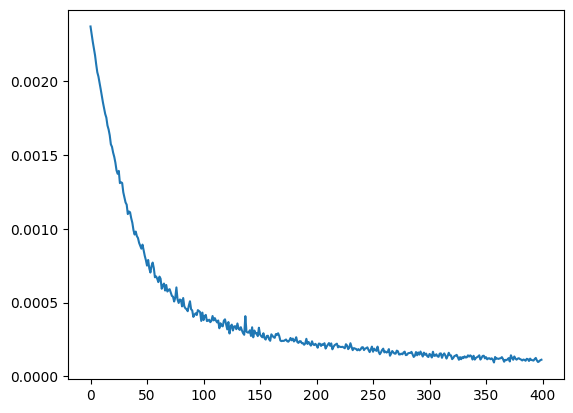

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
print(loss)

In [27]:
# ite = 100
# correct = 0
# for i in range(ite):
#     category, line, category_tensor, line_tensor = randomTestingExample()
#     output = evaluate(line_tensor)
#     predict = categoryFromOutput(output)
#     print(category,predict)
#     if int(category) == predict:
#         correct+=1
# correct = correct/ite

In [28]:
test_data = TensorDataset(torch.tensor(x_test,dtype=torch.float32).to(device),
                            torch.tensor(y_test,dtype=torch.long).to(device))

test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

correct = 0
for batch,data in enumerate(test_dataloader):
    input_batch, target_batch = data

    output = lstm(input_batch)

    top_n, top_i = output.topk(1,dim=1)  
    for i in range(top_i.shape[0]):
        predict_i = top_i[i].item()
        category_i = target_batch[i].item()
        print(category_i,predict_i)
        if int(category_i) == predict_i:
            correct+=1
correct = correct/(batch*batch_size)




0 0
1 1
0 0
0 0
1 1
0 0
0 1
0 0
0 0
2 2
0 0
1 1
1 1
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 1
0 0
1 1
0 0
0 1
0 0
0 0
0 0
1 1
0 0
0 0
1 1
1 1
2 2
0 0
0 0
0 0
2 2
2 2
0 0
0 0
2 2
0 0
0 0
0 0
2 2
0 0
0 0
0 0
0 0
0 0
0 0
2 2
0 0
0 0
0 1
0 1
1 1
0 0
0 2
1 1
0 0
0 0
0 0
0 0
2 2
0 0
1 1
0 0
0 0
0 0
0 1
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 1
0 0
1 1
2 2
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
2 2
2 2
0 0
1 1
0 0
0 0
0 1
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 1
1 1
0 0
0 0
0 0
0 1
0 0
0 1
0 0
2 2
0 0
0 0
0 1
0 0
0 0
2 2
0 0
0 0
0 0
0 0
0 2
0 0
2 2
0 0
2 2
1 1
2 2
1 1
0 0


In [29]:
correct

0.9296875

In [30]:
zscore_ca_trace = np.array([])
for i in range(len(valid_idx)):
    ca_trace = [float(k) for k in data_reader[valid_idx[i]].strip().split("\t")]
    if frame_correction:
        ca_trace_corrected_temp = ca_trace[0:frame_correction[0]+1]+ [float('NaN')]*frame_correction[1] + ca_trace[frame_correction[0]+1:-1]
        ca_trace_corrected = interpolateNaN(ca_trace_corrected_temp)

    else:
        ca_trace_corrected = ca_trace
    if i == 0:
        zscore_ca_trace = scipy.stats.zscore(ca_trace_corrected)
        zscore_ca_trace = np.expand_dims(zscore_ca_trace,axis=0)
        # print(zscore_ca_trace.shape)
    else:
        # print(zscore_ca_trace.shape)
        zscore_ca_trace = np.append(zscore_ca_trace,np.expand_dims(scipy.stats.zscore(ca_trace_corrected),axis=0),axis=0)

zscore_ca_trace_T = np.transpose(zscore_ca_trace)

In [31]:
def findClosestTimeIndex(t,tSeries):
    tDiff = [abs(t-i) for i in tSeries]
    nd_tDiff = np.array(tDiff)
    pos = np.argmin(nd_tDiff)
    return pos

trigger_variable = np.zeros((numData,1))

for i in np.arange(0,numTrig_poke,1):
    try:
        temp_pos = findClosestTimeIndex(trimmed_pokeTrigTime[i],caTime)
        
        trigger_variable[temp_pos,0]=1
    except:
        print('out of bound')

for i in np.arange(0,numTrig_lick,1):
    try:
        temp_pos = findClosestTimeIndex(trimmed_lickTrigTime[i],caTime)

        trigger_variable[temp_pos,0]=2
    except:
        print('out of bound')

out of bound
out of bound
out of bound
out of bound
out of bound
out of bound
out of bound
out of bound
out of bound
out of bound
out of bound
out of bound
out of bound


In [32]:
stride = int(len_window/2)
start_window = 1000 
stop_window = 7000 
predict_results = np.array([])
def slidingTestingExample(start_window,stride):
    
    features_tensor_temp= zscore_ca_trace[:,start_window-stride:start_window+stride]
    print(features_tensor_temp.shape)
    # features_vector = np.transpose(features_tensor_temp,(1,0))
    # features_tensor = lineToTensor(features_vector)
    features_tensor = torch.unsqueeze(torch.tensor(features_tensor_temp,dtype=torch.float32),0).to(device)
    return features_tensor

i = start_window 
while i<stop_window:
    line_tensor = slidingTestingExample(i,stride)
    output = lstm(line_tensor)
    
    top_n, top_i = output.topk(1)  

    predict = top_i[0].item()



    # predict = int(categoryFromOutput(output))
    predict_results = np.append(predict_results,predict)
    i += 1



(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)
(29, 200)


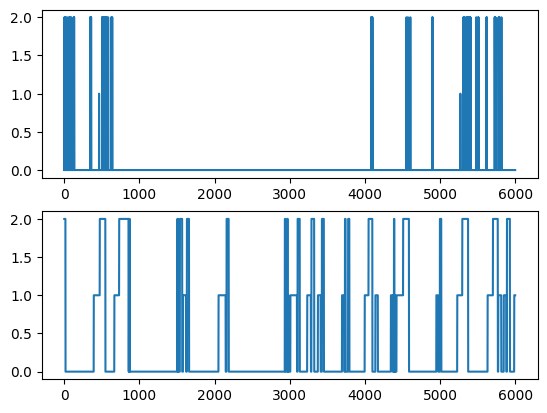

In [33]:
plt.subplot(2,1,1)
plt.plot(trigger_variable[start_window:stop_window])
plt.subplot(2,1,2)
plt.plot(predict_results)


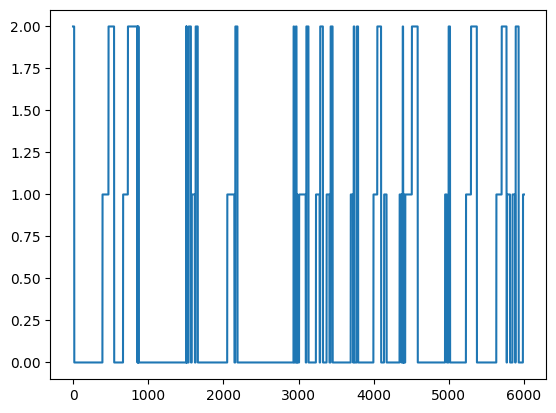

In [34]:
plt.plot(predict_results)

In [38]:
queries = torch.normal(0, 1, (2, 1, 2))


TypeError: normal() received an invalid combination of arguments - got (int, int), but expected one of:
 * (Tensor mean, Tensor std, *, torch.Generator generator, Tensor out)
 * (Tensor mean, float std, *, torch.Generator generator, Tensor out)
 * (float mean, Tensor std, *, torch.Generator generator, Tensor out)
 * (float mean, float std, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [36]:
queries.shape

torch.Size([2, 1, 2])